In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import rcParams
import matplotlib.transforms as mtransforms
from numpy import pi, sqrt, abs, real, imag
from matplotlib.colors import LinearSegmentedColormap

fontsize = 8
fonttype = 'serif'
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['figure.dpi'] = 150

if (fonttype == 'serif'):
    plt.rcParams['pdf.fonttype'] = 42
    mpl.rc('text', usetex=True)
    mpl.rc('text.latex', preamble=r'\usepackage{amsmath, newtxtext, newtxmath}')
    plt.rcParams['font.family'] = 'serif'
elif (fonttype == 'sans-serif'):
    plt.rcParams['pdf.fonttype'] = 42
    font = {'family': 'Arial', 
            'weight': 'medium',
            'style': 'normal'}
    mpl.rcParams['mathtext.fontset'] = 'custom'
    mpl.rcParams['mathtext.rm'] = 'Arial'
    mpl.rcParams['mathtext.it'] = 'Arial:italic'
    mpl.rc('font', **font)
    mpl.rc('text', usetex=False)
    from matplotlib.mathtext import _mathtext as mathtext
    mathtext.FontConstantsBase.sup1 = 0.5
    mathtext.FontConstantsBase.sub1 = 0.2
    mathtext.FontConstantsBase.sub2 = 0.2

index [k, j, i] 是按照 $(z,y,x)$ 的顺序

In [ ]:
def read_plt_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            data = file.read()
            shape = (N, N, N)
            psi = np.frombuffer(data, dtype=np.complex128).reshape(shape)
            return psi
    except FileNotFoundError:
        print(f"File {file_path} is not found.")
    except Exception as e:
        print(f"Error: {e}")

def compute_velocity(psi1, psi2, psi1_spec, psi2_spec, switch):
    rho = np.abs(psi1)**2 + np.abs(psi2)**2

    if (switch == 'SM'):
        dpsi1_x = np.fft.fftn(1j*KX*psi1_spec) / sqrt(N**3)
        dpsi1_y = np.fft.fftn(1j*KY*psi1_spec) / sqrt(N**3)
        dpsi1_z = np.fft.fftn(1j*KZ*psi1_spec) / sqrt(N**3)
        dpsi2_x = np.fft.fftn(1j*KX*psi2_spec) / sqrt(N**3)
        dpsi2_y = np.fft.fftn(1j*KY*psi2_spec) / sqrt(N**3)
        dpsi2_z = np.fft.fftn(1j*KZ*psi2_spec) / sqrt(N**3)
        ux = real(real(psi1)*imag(dpsi1_x) - imag(psi1)*real(dpsi1_x) + real(psi2)*imag(dpsi2_x) - imag(psi2)*real(dpsi2_x)) / rho
        uy = real(real(psi1)*imag(dpsi1_y) - imag(psi1)*real(dpsi1_y) + real(psi2)*imag(dpsi2_y) - imag(psi2)*real(dpsi2_y)) / rho
        uz = real(real(psi1)*imag(dpsi1_z) - imag(psi1)*real(dpsi1_z) + real(psi2)*imag(dpsi2_z) - imag(psi2)*real(dpsi2_z)) / rho
    elif (switch == 'FDM'):
        Jx = np.imag(np.conj(psi1) * (np.roll(psi1, -1, axis=2) - np.roll(psi1, 1, axis=2))) + np.imag(np.conj(psi2) * (np.roll(psi2, -1, axis=2) - np.roll(psi2, 1, axis=2)))
        Jy = np.imag(np.conj(psi1) * (np.roll(psi1, -1, axis=1) - np.roll(psi1, 1, axis=1))) + np.imag(np.conj(psi2) * (np.roll(psi2, -1, axis=1) - np.roll(psi2, 1, axis=1)))
        Jz = np.imag(np.conj(psi1) * (np.roll(psi1, -1, axis=0) - np.roll(psi1, 1, axis=0))) + np.imag(np.conj(psi2) * (np.roll(psi2, -1, axis=0) - np.roll(psi2, 1, axis=0)))
        h = 2*pi / N
        ux = Jx / (2*h) / rho
        uy = Jy / (2*h) / rho
        uz = Jz / (2*h) / rho
    return rho, ux, uy, uz

def compute_vorticity(ux, uy, uz, N, switch):
    if (switch == 'SM'):
        ux_spec = np.fft.fftn(ux)
        uy_spec = np.fft.fftn(uy)
        uz_spec = np.fft.fftn(uz)
        vorx = np.real(np.fft.ifftn(1j*(KY*uz_spec - KZ*uy_spec)))
        vory = np.real(np.fft.ifftn(1j*(KZ*ux_spec - KX*uz_spec)))
        vorz = np.real(np.fft.ifftn(1j*(KX*uy_spec - KY*ux_spec)))
    elif (switch == 'FDM'):
        h = 2*pi / N
        vorx = (np.roll(uz, -1, axis=1) - np.roll(uz, 1, axis=1)) - (np.roll(uy, -1, axis=0) - np.roll(uy, 1, axis=0))
        vory = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (np.roll(uz, -1, axis=2) - np.roll(uz, 1, axis=2))
        vorz = (np.roll(uy, -1, axis=2) - np.roll(uy, 1, axis=2)) - (np.roll(ux, -1, axis=1) - np.roll(ux, 1, axis=1))
        vorx = vorx / (2*h)
        vory = vory / (2*h)
        vorz = vorz / (2*h)
    return vorx, vory, vorz

def quantum_average(psi1, psi2, N, Nd):
    rho_qa = np.zeros((Nd, Nd, Nd))
    Jx_qa = np.zeros((Nd, Nd, Nd))
    Jy_qa = np.zeros((Nd, Nd, Nd))
    Jz_qa = np.zeros((Nd, Nd, Nd))

    size = N // Nd

    psi1_left_x = np.roll(psi1, size, axis=2)
    psi1_right_x = np.roll(psi1, -size, axis=2)  
    psi1_left_y = np.roll(psi1, size, axis=1)
    psi1_right_y = np.roll(psi1, -size, axis=1)
    psi1_left_z = np.roll(psi1, size, axis=0)
    psi1_right_z = np.roll(psi1, -size, axis=0)

    psi2_left_x = np.roll(psi1, size, axis=2)
    psi2_right_x = np.roll(psi1, -size, axis=2)  
    psi2_left_y = np.roll(psi1, size, axis=1)
    psi2_right_y = np.roll(psi1, -size, axis=1)
    psi2_left_z = np.roll(psi1, size, axis=0)
    psi2_right_z = np.roll(psi1, -size, axis=0)

    for k in range(Nd):
        for j in range(Nd):
            for i in range(Nd):
                rho_qa[k, j, i] = np.sum(np.abs(psi1[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)])**2) + np.sum(np.abs(psi2[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)])**2)
                Jx_qa[k, j, i] = np.imag(np.sum(psi1[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] * np.conj(psi1_left_x[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] - psi1_right_x[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)]))) + np.imag(np.sum(psi2[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] * np.conj(psi2_left_x[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] - psi2_right_x[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)])))
                Jy_qa[k, j, i] = np.imag(np.sum(psi1[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] * np.conj(psi1_left_y[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] - psi1_right_y[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)]))) + np.imag(np.sum(psi2[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] * np.conj(psi2_left_y[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] - psi2_right_y[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)])))
                Jz_qa[k, j, i] = np.imag(np.sum(psi1[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] * np.conj(psi1_left_z[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] - psi1_right_z[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)]))) + np.imag(np.sum(psi2[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] * np.conj(psi2_left_z[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)] - psi2_right_z[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)])))
    
    h = 2*pi / N
    velx_qa = Jx_qa / rho_qa / (2*h)
    vely_qa = Jy_qa / rho_qa / (2*h)
    velz_qa = Jz_qa / rho_qa / (2*h)

    vorx_qa, vory_qa, vorz_qa = compute_vorticity(velx_qa, vely_qa, velz_qa, Nd, 'FDM')
    return rho_qa, Jx_qa, Jy_qa, Jz_qa, velx_qa, vely_qa, velz_qa, vorx_qa, vory_qa, vorz_qa

def spatial_average(rho, ux, uy, uz, N, Nd):
    rho_sa = np.zeros((Nd, Nd, Nd))
    Jx_sa = np.zeros((Nd, Nd, Nd))
    Jy_sa = np.zeros((Nd, Nd, Nd))
    Jz_sa = np.zeros((Nd, Nd, Nd))

    Jx = ux * rho
    Jy = uy * rho
    Jz = uz * rho

    size = N // Nd

    for k in range(Nd):
        for j in range(Nd):
            for i in range(Nd):
                rho_sa[k, j, i] = np.sum(rho[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)])
                Jx_sa[k, j, i] = np.sum(Jx[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)])
                Jy_sa[k, j, i] = np.sum(Jy[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)])
                Jz_sa[k, j, i] = np.sum(Jz[size*k:size*(k+1), size*j:size*(j+1), size*i:size*(i+1)])
    ux_sa = Jx_sa / rho_sa
    uy_sa = Jy_sa / rho_sa
    uz_sa = Jz_sa / rho_sa

    vorx_sa, vory_sa, vorz_sa = compute_vorticity(ux_sa, uy_sa, uz_sa, Nd, 'FDM')
    return rho_sa, ux_sa, uy_sa, uz_sa, vorx_sa, vory_sa, vorz_sa

def compute_Ek(ux, uy, uz, ik2, N):
    ux_spec = np.fft.fftn(ux) / N**3
    uy_spec = np.fft.fftn(uy) / N**3
    uz_spec = np.fft.fftn(uz) / N**3
    energy_spec = (np.abs(ux_spec)**2 + np.abs(uy_spec)**2 + np.abs(uz_spec)**2) / 2

    nek = N//3
    Ek = np.zeros(nek)
    k = np.linspace(1, nek, nek)
    for i in range(1, nek+1):
        Ek[i-1] = k[i-1]*np.sum(energy_spec[ik2 == i])
    return k, Ek

def compute_velocity_gradient(ux, uy, uz, N, switch):
    if (switch == 'SM'):
        vgt11 = np.real(np.fft.ifftn(1j*KX*np.fft.fftn(ux)))
        vgt12 = np.real(np.fft.ifftn(1j*KY*np.fft.fftn(ux)))
        vgt13 = np.real(np.fft.ifftn(1j*KZ*np.fft.fftn(ux)))

        vgt21 = np.real(np.fft.ifftn(1j*KX*np.fft.fftn(uy)))
        vgt22 = np.real(np.fft.ifftn(1j*KY*np.fft.fftn(uy)))
        vgt23 = np.real(np.fft.ifftn(1j*KZ*np.fft.fftn(uy)))

        vgt31 = np.real(np.fft.ifftn(1j*KX*np.fft.fftn(uz)))
        vgt32 = np.real(np.fft.ifftn(1j*KY*np.fft.fftn(uz)))
        vgt33 = np.real(np.fft.ifftn(1j*KZ*np.fft.fftn(uz)))
    elif (switch == 'FDM'):
        h = 2*np.pi / N
        vgt11 = (np.roll(ux, -1, axis=2) - np.roll(ux, 1, axis=2)) / (2*h)
        vgt12 = (np.roll(ux, -1, axis=1) - np.roll(ux, 1, axis=1)) / (2*h)
        vgt13 = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) / (2*h)

        vgt21 = (np.roll(uy, -1, axis=2) - np.roll(uy, 1, axis=2)) / (2*h)
        vgt22 = (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1)) / (2*h)
        vgt23 = (np.roll(uy, -1, axis=0) - np.roll(uy, 1, axis=0)) / (2*h)

        vgt31 = (np.roll(uz, -1, axis=2) - np.roll(uz, 1, axis=2)) / (2*h)
        vgt32 = (np.roll(uz, -1, axis=1) - np.roll(uz, 1, axis=1)) / (2*h)
        vgt33 = (np.roll(uz, -1, axis=0) - np.roll(uz, 1, axis=0)) / (2*h)
    return vgt11, vgt12, vgt13, vgt21, vgt22, vgt23, vgt31, vgt32, vgt33


N = 2**9
kx = np.fft.fftfreq(N)*N
ky = np.fft.fftfreq(N)*N
kz = np.fft.fftfreq(N)*N
KX, KY, KZ = np.meshgrid(kx, ky, kz)
K2 = KX**2 + KY**2 + KZ**2
ik2 = np.round(sqrt(K2))

psi1_spec = read_plt_file(fr'psi1_3D-{N}.plt')
psi2_spec = read_plt_file(fr'psi2_3D-{N}.plt')

psi1 = np.fft.fftn(psi1_spec) / sqrt(N**3)
psi2 = np.fft.fftn(psi2_spec) / sqrt(N**3)

rho, ux, uy, uz = compute_velocity(psi1, psi2, psi1_spec, psi2_spec, 'FDM')

vorx, vory, vorz = compute_vorticity(ux, uy, uz, N, 'FDM')
vor2 = vorx**2 + vory**2 + vorz**2

画速度、涡量PDF

In [ ]:
def compute_pdf(variable, Num, bin_num):
    bin_size = (np.amax(variable) - np.amin(variable)) / bin_num
    counts, bin_edges = np.histogram(variable, bins=bin_num, range=(np.amin(variable), np.amax(variable)))
    pdf = counts / (Num * bin_size)
    val = bin_edges[:-1] + bin_size / 2
    return val, pdf

u2 = ux**2 + uy**2 + uz**2
h = 2*np.pi / N
tke = np.sum(u2)/2*h**3
u_prime = sqrt(2*tke/3)
print('Total kinetic energy:', tke)
print('Mean velocity:', u_prime)

enstrophy = np.sum(vor2) / 2*h**3
vor_prime = np.sqrt(2*enstrophy/3)
print('Enstrophy:', enstrophy)

vel = np.array([ux, uy, uz])
val_u, pdf_u = compute_pdf(vel, 3*N**3, 150)
# val_ux, pdf_ux = compute_pdf(ux, N**3, 150)
# val_uy, pdf_uy = compute_pdf(uy, N**3, 150)
# val_uz, pdf_uz = compute_pdf(uz, N**3, 150)

vor = np.array([vorx, vory, vorz])
val_vor, pdf_vor = compute_pdf(vor, 3*N**3, 150)

Total kinetic energy: 23625.004530880917
Mean velocity: 125.49901601441853
Enstrophy: 1628184.5990112724


Structure functions

In [ ]:
def calculate_structure_function(ux, uy, uz, p, n_samples=1_000_000, n_bins=50):
    Nx, Ny, Nz = ux.shape

    i1 = np.random.randint(0, Nx, size=n_samples)
    j1 = np.random.randint(0, Ny, size=n_samples)
    k1 = np.random.randint(0, Nz, size=n_samples)
    i2 = np.random.randint(0, Nx, size=n_samples)
    j2 = np.random.randint(0, Ny, size=n_samples)
    k2 = np.random.randint(0, Nz, size=n_samples)

    dr_x = i2.astype(float) - i1.astype(float)
    dr_y = j2.astype(float) - j1.astype(float)
    dr_z = k2.astype(float) - k1.astype(float)
    r = np.sqrt(dr_x**2 + dr_y**2 + dr_z**2)
    
    valid_mask = r > 0
    if not np.any(valid_mask):
        print("warning")
        return np.array([]).reshape(-1, 1), np.array([]).reshape(-1, 1)
        
    r = r[valid_mask]
    dr_x, dr_y, dr_z = dr_x[valid_mask], dr_y[valid_mask], dr_z[valid_mask]
    i1, j1, k1 = i1[valid_mask], j1[valid_mask], k1[valid_mask]
    i2, j2, k2 = i2[valid_mask], j2[valid_mask], k2[valid_mask]

    u1 = np.array([ux[i1, j1, k1], uy[i1, j1, k1], uz[i1, j1, k1]])
    u2 = np.array([ux[i2, j2, k2], uy[i2, j2, k2], uz[i2, j2, k2]])
    du = u2 - u1

    du_long = np.einsum('ij,ij->j', du, np.array([dr_x, dr_y, dr_z])) / r
    sp_values = np.abs(du_long)**p

    max_r = np.sqrt(Nx**2 + Ny**2 + Nz**2)
    r_bins = np.logspace(np.log10(1.0), np.log10(max_r), n_bins + 1)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])

    bin_indices = np.digitize(r, r_bins) - 1

    valid_bin_mask = (bin_indices >= 0) & (bin_indices < n_bins)
    
    bin_sums = np.bincount(
        bin_indices[valid_bin_mask],
        weights=sp_values[valid_bin_mask],
        minlength=n_bins
    )
    bin_counts = np.bincount(
        bin_indices[valid_bin_mask],
        minlength=n_bins
    )

    Sp = np.zeros_like(r_centers)
    non_zero_counts = bin_counts > 0
    Sp[non_zero_counts] = bin_sums[non_zero_counts] / bin_counts[non_zero_counts]

    # from scipy.interpolate import UnivariateSpline
    # spline = UnivariateSpline(r_centers, Sp, s=30)
    # Sp = spline(r_centers) 

    return r_centers.reshape(-1), Sp.reshape(-1)

r, s2 = calculate_structure_function(ux, uy, uz, 2, n_samples=3_000_000_000, n_bins=50)
r, s3 = calculate_structure_function(ux, uy, uz, 3, n_samples=3_000_000_000, n_bins=50)
r, s4 = calculate_structure_function(ux, uy, uz, 4, n_samples=3_000_000_000, n_bins=50)
r, s5 = calculate_structure_function(ux, uy, uz, 5, n_samples=3_000_000_000, n_bins=50)

网格维度: 512x512x512
计算 2 阶结构函数，使用 300,000,000 个样本点对...
网格维度: 512x512x512
计算 3 阶结构函数，使用 300,000,000 个样本点对...
网格维度: 512x512x512
计算 4 阶结构函数，使用 300,000,000 个样本点对...
网格维度: 512x512x512
计算 5 阶结构函数，使用 300,000,000 个样本点对...


In [20]:
import pandas as pd

header_names = [
    'r', 
    's2', 
    's3', 
    's4', 
    's5'
    # 's6', 
    # 's7', 
    # 's8'
]

r = r.reshape(-1)
s2 = s2.reshape(-1)
s3 = s3.reshape(-1)
s4 = s4.reshape(-1)
s5 = s5.reshape(-1)
# s6 = s6.reshape(-1)
# s7 = s7.reshape(-1)
# s8 = s8.reshape(-1)

data_dict = dict(zip(header_names, [r, s2, s3, s4, s5]))
df = pd.DataFrame(data_dict)
output_filename = fr'data/3D/structure_functions.csv'
df.to_csv(output_filename, index=False)

0.6539447261849197
0.9534743800026608
1.2193717676546585
1.5510455995277683


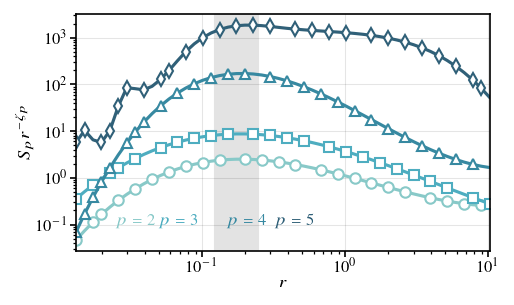

In [ ]:
fig_width = 18/2.54
fig_height = 18/2.54
fig = plt.figure(figsize=(fig_width, fig_height))

ax_width = 7/2.54 / fig_width
ax_height = 4/2.54 / fig_height

from matplotlib.colors import LinearSegmentedColormap, to_hex
cmap_deep = LinearSegmentedColormap.from_list('cmap_deep', ['#231B32', '#3CA4BD', '#F8FFD7'])

# 
ax = fig.add_axes([0, 0, ax_width, ax_height])

def zeta(p):
    return p/9 + 2*(1 - (2/3)**(p/3))

df = pd.read_csv(fr'data/3D/structure_functions.csv', header=0)
r = np.array(df['r'].tolist())
s2 = np.array(df['s2'].tolist())
s3 = np.array(df['s3'].tolist()) 
s4 = np.array(df['s4'].tolist()) 
s5 = np.array(df['s5'].tolist()) 

dx = 2*np.pi / 512

from scipy.interpolate import UnivariateSpline

ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1)

plt.loglog(r*dx, s2*r**(-zeta(2)), marker='o', markersize=5, markevery=0.04, markerfacecolor='white', markeredgecolor=to_hex(cmap_deep(0.7)), markeredgewidth=1, color=to_hex(cmap_deep(0.7)))
plt.text(2*dx, 0.1, r'$p=2$', color=to_hex(cmap_deep(0.7)))
coeffs = np.polyfit(np.log(r[17:24]), np.log(s2[17:24]), 1)
print(coeffs[0])

slope = coeffs[0]
intercept = coeffs[1]

plt.loglog(r*dx, s3*r**(-zeta(3)), marker='s', markersize=4.5, markevery=0.04, markerfacecolor='white', markeredgecolor=to_hex(cmap_deep(0.55)), markeredgewidth=1, color=to_hex(cmap_deep(0.55)))
plt.text(4*dx, 0.1, r'$p=3$', color=to_hex(cmap_deep(0.55)))
coeffs = np.polyfit(np.log(r[17:24]), np.log(s3[17:24]), 1)
print(coeffs[0])

plt.loglog(r*dx, s4*r**(-zeta(4)), marker='^', markersize=5, markevery=0.04, markerfacecolor='white', markeredgecolor=to_hex(cmap_deep(0.4)), markeredgewidth=1, color=to_hex(cmap_deep(0.4)))
plt.text(12*dx, 0.1, r'$p=4$', color=to_hex(cmap_deep(0.4)))
coeffs = np.polyfit(np.log(r[17:24]), np.log(s4[17:24]), 1)
print(coeffs[0])

plt.loglog(r*dx, s5*r**(-zeta(5)), marker='d', markersize=5, markevery=0.04, markerfacecolor='white', markeredgecolor=to_hex(cmap_deep(0.25)), markeredgewidth=1, color=to_hex(cmap_deep(0.25)))
plt.text(26*dx, 0.1, r'$p=5$', color=to_hex(cmap_deep(0.25)))
coeffs = np.polyfit(np.log(r[17:26]), np.log(s5[17:26]), 1)
print(coeffs[0])

plt.axvspan(xmin=10*dx, xmax=20*dx, color='#E3E3E3')

# ax.legend(ncol=1, frameon=True, labelspacing=0.2, handlelength=2, handletextpad=0.5, bbox_to_anchor=(1.2, 0), loc='lower left', fontsize=fontsize-1)
plt.xlim(np.min(r)*dx, np.max(r)*dx) 
# plt.ylim(0, 1)
plt.xlabel(r'$r$', labelpad=0, size=fontsize)
plt.ylabel(r'$S_p r^{-\zeta_p}$', labelpad=1, size=fontsize) # rotation=0
# ax.set_yticks(np.linspace(-1, 1, 3))
# ax.set_yticklabels([r'$10^{-1}$', r'$10^0$', r'$10^1$'])
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, length=3, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, length=3, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=1.5)

# 
plt.savefig(fr'figure.pdf', transparent=True, orientation='portrait', format='pdf', bbox_inches='tight')

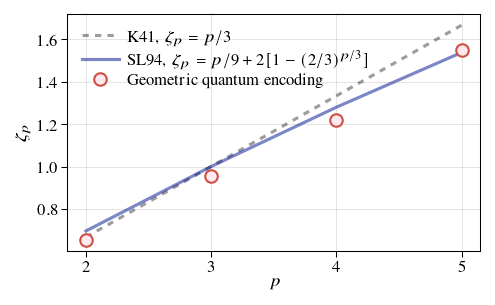

In [5]:
p = np.linspace(2, 5, num=4)
zeta_p = [0.6539447261849197, 0.9534743800026608, 1.2193717676546585, 1.5510455995277683]

K41 = p / 3
SL94 = p / 9 + 2 * (1 - (2/3)**(p/3))

fig_width = 18/2.54
fig_height = 18/2.54
fig = plt.figure(figsize=(fig_width, fig_height))

ax_width = 7/2.54 / fig_width
ax_height = 4/2.54 / fig_height

# 
ax = fig.add_axes([0, 0, ax_width, ax_height])

ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1)
ax.plot(p, K41, linestyle='--', dashes=(2, 2), label='K41, $\zeta_p=p/3$', color="#00000062")
ax.plot(p, SL94, label='SL94, $\zeta_p=p/9+2[1-(2/3)^{p/3}]$', color="#04179485")
ax.plot(p, zeta_p, linestyle='none', marker='o', markersize=6, markevery=(0.03/2, 0.03), markerfacecolor='#FFE9F1', markeredgecolor='#CE5044', markeredgewidth=1, label='Geometric quantum encoding')

ax.legend(ncol=1, frameon=False, labelspacing=0.2, handlelength=2.2, handletextpad=0.5, bbox_to_anchor=(0, 1), loc='upper left', fontsize=fontsize)
# plt.xlim(0, 1) 
# plt.ylim(0, 1)
plt.xlabel(r'$p$', labelpad=0, size=fontsize)
plt.ylabel(r'$\zeta_p$', labelpad=3, size=fontsize) # rotation=0
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.set_xticks(np.linspace(2, 5, 4))
# ax.set_yticklabels([r'$10^{-1}$', r'$10^0$', r'$10^1$'])
# ax.yaxis.set_minor_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, length=3, width=0.5, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, length=3, width=0.5, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=1.5, width=0.5)

# 
plt.savefig(fr'figure.pdf', transparent=True, orientation='portrait', format='pdf', bbox_inches='tight')

QR-plot

In [4]:
def compute_RQ(ux, uy, uz, N):
    vgt11, vgt12, vgt13, vgt21, vgt22, vgt23, vgt31, vgt32, vgt33 = compute_velocity_gradient(ux, uy, uz, N, 'FDM')
    Q = -0.5*(vgt11**2 + vgt22**2 + vgt33**2 + 2*vgt12*vgt21 + 2*vgt13*vgt31 + 2*vgt23*vgt32)
    R = -(vgt11*(vgt22*vgt33-vgt32*vgt23) - vgt12*(vgt21*vgt33-vgt31*vgt23) + vgt13*(vgt21*vgt32-vgt31*vgt22))
    return R, Q 

def compute_jointpdf(data1, data2, bin_num):
    binsize_1 = (np.max(data1) - np.min(data1)) / bin_num
    binsize_2 = (np.max(data2) - np.min(data2)) / bin_num
    counts, x_edges, y_edges = np.histogram2d(data1.flatten(), data2.flatten(), bins=bin_num)
    pdf = counts / (binsize_1 * binsize_2 * data1.size)
    val1 = x_edges[:-1] + binsize_1 / 2
    val2 = y_edges[:-1] + binsize_2 / 2
    return val1, val2, pdf

R, Q = compute_RQ(ux, uy, uz, N)
val_R, val_Q, pdf = compute_jointpdf(R, Q, 200)

231262600999.17 -226406828782.4484
75376336.42961718 -400232037.12832963
1.8157547809191967e-16 0.0


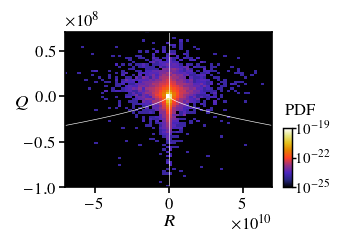

In [99]:
print(np.amax(val_R), np.amin(val_R))
print(np.amax(val_Q), np.amin(val_Q))
print(np.amax(pdf), np.amin(pdf))

fig_width = 18/2.54
fig_height = 18/2.54
fig = plt.figure(figsize=(fig_width, fig_height))

ax_width = 3.5/2.54 / fig_width
ax_height = ax_width / 4 * 3
cbar_length = 1/2.54 / fig_width
cbar_width = 1.2/8/2.54 / fig_width

# 
ax = fig.add_axes([0, 0, ax_width, ax_height])

R, Q = np.meshgrid(val_R, val_Q, indexing='ij')
ax.pcolormesh(R, Q, np.log10(pdf+1e-100), cmap='CMRmap', vmin=-25, vmax=-19, rasterized=True)
ax.axvline(x=0, linewidth=0.3, color='white')
# ax.axhline(y=0, linewidth=0.25, color='white')
R0 = np.linspace(np.amin(R), np.amax(R), 3000)
ax.plot(R0, -3*(R0**2/4)**(1/3), linewidth=0.3, color='white')

from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formatter)

plt.xlim(-7e10, 7e10) 
plt.ylim(-1e8, 7e7)
plt.xlabel(r'$R$', labelpad=1, size=fontsize)
plt.ylabel(r'$Q$', labelpad=1, size=fontsize, rotation=0) # rotation=0
# ax.set_xticks(np.linspace(-2e8, 2e8, 5))
# ax.set_yticks(np.linspace(-1.6e6, 1.6e6, 3))
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, length=3, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, length=3, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=1.5)

cax = fig.add_axes([ax_width+0.01, 0, cbar_width, cbar_length])
cbar = plt.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=0, vmax=1), 'CMRmap'), ax=ax, cax=cax, orientation='vertical', ticks=[0, 0.5, 1], location='right')
cbar.set_ticklabels(['$10^{-25}$', '$10^{-22}$', '$10^{-19}$'])
cax.text(2, 1.3, 'PDF', ha='center', va='center')
cbar.ax.tick_params(length=2, width=0.7, labelsize=fontsize-1, pad=0)
cbar.outline.set_linewidth(0.7)


# 
# plt.savefig(fr'figures/RQ.pdf', transparent=True, orientation='portrait', format='pdf', bbox_inches='tight', dpi=600)

Plot iso-surface of vorticity magnitude

In [ ]:
x = np.linspace(0, 2*np.pi, N)
y = np.linspace(0, 2*np.pi, N)
z = np.linspace(0, 2*np.pi, N)
X, Y, Z = np.meshgrid(x, y, z)

helicity = vorx*ux + vory*uy + vorz*uz

cmap_BuRd = LinearSegmentedColormap.from_list('cmap_BuRd', ['#1763b2', '#86c5e5', '#ffffff', '#f69d74', '#b80f24'])

import pyvista as pv
from scipy.interpolate import RegularGridInterpolator

grid = pv.StructuredGrid(X, Y, Z)

grid.point_data['vor'] = np.sqrt(vor2).flatten(order='F') 
grid.point_data['helicity'] = helicity.flatten(order='F')

plotter = pv.Plotter(notebook=False, off_screen=True)   # output to file: off_screen=True

contours = grid.contour(isosurfaces=[200], scalars='vor')

if hasattr(contours, 'smooth'):
    contours = contours.smooth(n_iter=100, relaxation_factor=0.1)

bounds = contours.bounds

plotter.add_mesh(contours, scalars='helicity', cmap=cmap_BuRd, clim=[-3000, 3000], opacity=0.7)
plotter.add_mesh(pv.Box(bounds=bounds), color='white', style='wireframe', line_width=10)
plotter.remove_scalar_bar()

def add_background_plane(plotter, position, normal, size, color='black'):
    plane = pv.Plane(center=position, direction=normal, i_size=size[0], j_size=size[1])
    plotter.add_mesh(plane, color=color, opacity=1)

background_planes = [
    {
        'position': (2*np.pi, (bounds[2] + bounds[3]) / 2, (bounds[4] + bounds[5]) / 2), 
        'normal': (1, 0, 0), 
        'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), (bounds[5] - bounds[4]))
    },
    {
        'position': ((bounds[0] + bounds[1]) / 2, 0, (bounds[4] + bounds[5]) / 2), 
        'normal': (0, -1, 0), 
        'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), (bounds[5] - bounds[4]))
    },
    {
        'position': ((bounds[0] + bounds[1]) / 2, (bounds[2] + bounds[3]) / 2, 0), 
        'normal': (0, 0, -1), 
        'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), 0)
    }
]

for plane in background_planes:
    add_background_plane(plotter, **plane)

plotter.enable_anti_aliasing() 
light = pv.Light()
light.intensity = 0.5       
light.positional = True     
light.position = (6, 9, 9)  
# light.show_actor()           
plotter.add_light(light)

plotter.camera.azimuth = 70
plotter.camera.elevation = -15
plotter.disable_parallel_projection() 

# plotter.show_grid()

plotter.show(screenshot=fr'figures/iso-vor.png', window_size=[3000, 3000])

isosurface Q criteria

In [ ]:
x = np.linspace(0, 2*np.pi, N)
y = np.linspace(0, 2*np.pi, N)
z = np.linspace(0, 2*np.pi, N)
X, Y, Z = np.meshgrid(x, y, z)

helicity = vorx*ux + vory*uy + vorz*uz

import pyvista as pv
from scipy.interpolate import RegularGridInterpolator

grid = pv.StructuredGrid(X, Y, Z)

grid.point_data['Q'] = Q.flatten(order='F')  
grid.point_data['helicity'] = helicity.flatten(order='F')

plotter = pv.Plotter(notebook=False, off_screen=False)   # output to file: off_screen=True

contours = grid.contour(isosurfaces=[5e3], scalars='Q')

if hasattr(contours, 'smooth'):
    contours = contours.smooth(n_iter=100, relaxation_factor=0.1)

bounds = contours.bounds

plotter.add_mesh(contours, scalars='helicity', cmap=cmap_BuRd, clim=[-2000, 2000], opacity=0.7)
plotter.add_mesh(pv.Box(bounds=bounds), color='white', style='wireframe', line_width=10)
plotter.remove_scalar_bar()

def add_background_plane(plotter, position, normal, size, color='black'):
    plane = pv.Plane(center=position, direction=normal, i_size=size[0], j_size=size[1])
    plotter.add_mesh(plane, color=color, opacity=1)

background_planes = [
    {
        'position': (2*np.pi, (bounds[2] + bounds[3]) / 2, (bounds[4] + bounds[5]) / 2), 
        'normal': (1, 0, 0), 
        'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), (bounds[5] - bounds[4]))
    },
    {
        'position': ((bounds[0] + bounds[1]) / 2, 0, (bounds[4] + bounds[5]) / 2), 
        'normal': (0, -1, 0), 
        'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), (bounds[5] - bounds[4]))
    },
    {
        'position': ((bounds[0] + bounds[1]) / 2, (bounds[2] + bounds[3]) / 2, 0), 
        'normal': (0, 0, -1), 
        'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), 0)
    }
]

for plane in background_planes:
    add_background_plane(plotter, **plane)

plotter.enable_anti_aliasing()  
light = pv.Light()
light.intensity = 0.5       
light.positional = True      
light.position = (6, 9, 9)   
# light.show_actor()          
plotter.add_light(light)

plotter.camera.azimuth = 70
plotter.camera.elevation = -15
plotter.disable_parallel_projection()   

# plotter.show_grid()

plotter.show(screenshot=fr'figures/iso-Q.png', window_size=[3000, 3000])

Plot iso-surfaces of spin vector components

In [12]:
s1 = 2*(np.real(psi1)*np.real(psi2) + np.imag(psi1)*np.imag(psi2)) / rho
s2 = 2*(np.real(psi1)*np.imag(psi2) - np.imag(psi1)*np.real(psi2)) / rho
s3 = (np.abs(psi1)**2 - np.abs(psi2)**2) / rho

In [ ]:
x = np.linspace(0, 2*np.pi, N)
y = np.linspace(0, 2*np.pi, N)
z = np.linspace(0, 2*np.pi, N)
X, Y, Z = np.meshgrid(x, y, z)

import pyvista as pv
from scipy.interpolate import RegularGridInterpolator

grid = pv.StructuredGrid(X, Y, Z)

grid.point_data['s'] = s1.flatten(order='F') 
grid.point_data['vor'] = np.sqrt(vor2).flatten(order='F')

plotter = pv.Plotter(notebook=False, off_screen=True)   # output to file: off_screen=True

contours = grid.contour(isosurfaces=[-0.8], scalars='s')

if hasattr(contours, 'smooth'):
    contours = contours.smooth(n_iter=100, relaxation_factor=0.1)

bounds = contours.bounds

plotter.add_mesh(contours, scalars='vor', cmap='cividis', clim=[0, 200], opacity=0.7)
plotter.add_mesh(pv.Box(bounds=bounds), color='white', style='wireframe', line_width=10)
plotter.remove_scalar_bar()

def add_background_plane(plotter, position, normal, size, color='black'):
    plane = pv.Plane(center=position, direction=normal, i_size=size[0], j_size=size[1])
    plotter.add_mesh(plane, color=color, opacity=1)

background_planes = [
    {
        'position': (2*np.pi, (bounds[2] + bounds[3]) / 2, (bounds[4] + bounds[5]) / 2), 
        'normal': (1, 0, 0), 
        'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), (bounds[5] - bounds[4]))
    },
    {
        'position': ((bounds[0] + bounds[1]) / 2, 0, (bounds[4] + bounds[5]) / 2), 
        'normal': (0, -1, 0), 
        'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), (bounds[5] - bounds[4]))
    },
    {
        'position': ((bounds[0] + bounds[1]) / 2, (bounds[2] + bounds[3]) / 2, 0), 
        'normal': (0, 0, -1), 
        'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), 0)
    }
]

for plane in background_planes:
    add_background_plane(plotter, **plane)

plotter.enable_anti_aliasing()  
light = pv.Light()
light.intensity = 0.5       
light.positional = True     
light.position = (6, 9, 9)   
# light.show_actor()          
plotter.add_light(light)

plotter.camera.azimuth = 70
plotter.camera.elevation = -15
plotter.disable_parallel_projection()    

# plotter.show_grid()

plotter.show(screenshot=fr'figures/iso-s.png', window_size=[3000, 3000])

Plot the scalar spectrum of $\vec{s}$

In [13]:
def compute_Es(s, ik2, N):
    s_spec = np.fft.fftn(s) / N**3
    energy_spec = np.abs(s_spec)**2 / 2
    
    nek = N
    Es = np.zeros(nek)
    k = np.linspace(1, nek, nek)
    for i in range(1, nek+1):
        Es[i-1] = k[i-1]*np.sum(energy_spec[ik2 == i])
    return k, Es

k, Es1 = compute_Es(s1, ik2, N)
k, Es2 = compute_Es(s2, ik2, N)
k, Es3 = compute_Es(s3, ik2, N)

Spectrum

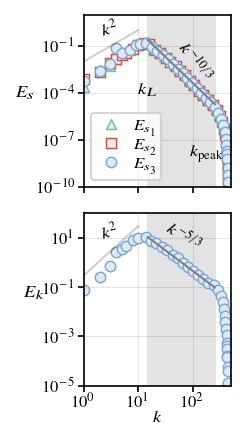

In [15]:
fig_width = 15/2.54
fig_height = 15/2.54
fig = plt.figure(figsize=(fig_width, fig_height))

ax_width = 2.5/2.54 / fig_width
ax_height = ax_width / 3 * 3.5
cbar_length = 1/2.54 / fig_width
cbar_width = 1.2/8/2.54 / fig_width

# 
ax = fig.add_axes([0, 0, ax_width, ax_height])

ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1)
ax.loglog(k, Es1, linestyle='none', marker='^', markersize=5, markevery=(0, 0.03), markerfacecolor='#dfeddc', markeredgecolor='#66c2a5', alpha=1, markeredgewidth=0.7, label=r'$E_{s_1}$')
ax.loglog(k, Es2, linestyle='none', marker='s', markersize=5, markevery=(0.03/2, 0.03), markerfacecolor='#FFE9F1', markeredgecolor='#CE5044', alpha=1, markeredgewidth=0.7, label=r'$E_{s_2}$')
ax.loglog(k, Es3, linestyle='none', marker='o', markersize=5, markevery=(0.03/2, 0.03), markerfacecolor='#DDE9F5', markeredgecolor='#7AA7D3', alpha=1, markeredgewidth=0.7, label=r'$E_{s_3}$')
ax.loglog(np.linspace(15, 256, 100), 2e3*np.linspace(15, 256, 100)**(-10/3), linestyle='-', linewidth=1, color='grey')
ax.loglog(np.linspace(1, 10, 100), 0.01*np.linspace(1, 10, 100)**2, linewidth=1, color="#00000030")
ax.text(2, 0.5, r'$k^2$', rotation=15)
ax.text(50, 5e-4, r'$k^{-10/3}$', rotation=-55)
ax.text(10, 1e-4, r'$k_L$')
ax.text(90, 1e-8, r'$k_{\mathrm{peak}}$')
# ax.text(2.5, 1e-7, r'$k^2$', rotation=0)
# ax.text(50, 1e-7, r'$\mathrm{e}^{-k/2}$', rotation=0)
ax.axvspan(xmin=15, xmax=256, color='#E3E3E3')
ax.legend(ncol=1, frameon=True, labelspacing=0.2, handlelength=2, handletextpad=0.5, bbox_to_anchor=(0, 0), loc='lower left', fontsize=fontsize-1)
plt.xlim(1, N)
plt.ylim(1e-10, 1e1)
# plt.xlabel(r'$k$', labelpad=0, size=fontsize)
plt.ylabel(r'$E_s$', rotation=0, labelpad=6, size=fontsize)
ax.set_xticklabels([])
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, length=3, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, length=3, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=0)


# 
ax = fig.add_axes([0, -ax_height-0.03, ax_width, ax_height])
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1)
ax.loglog(k, Ek, linestyle='none', marker='o', markersize=5, markevery=(0.03/2, 0.03), markerfacecolor='#DDE9F5', markeredgecolor='#7AA7D3', markeredgewidth=0.7)
ax.loglog(np.linspace(15, 256, 100), 1e3*np.linspace(15, 256, 100)**(-5/3), linestyle='-', linewidth=1, color='grey')
ax.loglog(np.linspace(1, 10, 100), 0.3*np.linspace(1, 10, 100)**2, linewidth=1, color="#00000030")
# ax.loglog(np.linspace(15, N//3, 100), np.exp(-0.5*np.linspace(15, N//3, 100)), linestyle='--', dashes=(2, 2), color='k')
ax.text(2, 10, r'$k^2$', rotation=15)
ax.text(30, 3, r'$k^{-5/3}$', rotation=-35)
ax.axvspan(xmin=15, xmax=256, color='#E3E3E3')
# ax.text(2.5, 1e-7, r'$k^2$', rotation=0)
# ax.text(50, 1e-7, r'$\mathrm{e}^{-k/2}$', rotation=0)
plt.xlim(1, N)
plt.ylim(1e-5, 1e2)
plt.xlabel(r'$k$', labelpad=0, size=fontsize)
plt.ylabel(r'$E_k$', rotation=0, labelpad=5, size=fontsize)
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, length=3, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, length=3, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=0)


# 
plt.savefig(fr'figures/spectrum.pdf', transparent=True, orientation='portrait', format='pdf', bbox_inches='tight')


Statistics

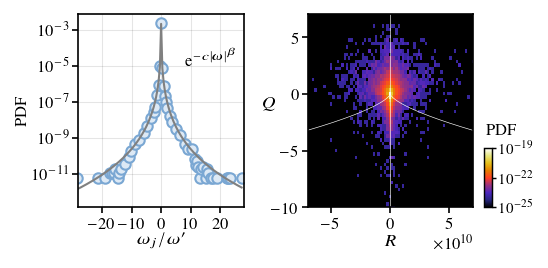

In [ ]:
fig_width = 18/2.54
fig_height = 18/2.54
fig = plt.figure(figsize=(fig_width, fig_height))

ax_width = 2.8/2.54 / fig_width
ax_height = ax_width / 3 * 3.5


# 
ax = fig.add_axes([0, 0, ax_width, ax_height])
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1)
ax.plot(val_vor/vor_prime, pdf_vor, linestyle='none', marker='o', markersize=5, markevery=(0, 0.03), markerfacecolor='#DDE9F5', markeredgecolor='#7AA7D3', markeredgewidth=1)
fx = val_vor/vor_prime
s = np.sqrt(np.var(np.log(np.abs(fx))))
m = np.mean(np.log(np.abs(fx)))
fy = 1 / (2*np.abs(fx)*s*np.sqrt(2*np.pi)) * np.exp(-(np.log(np.abs(fx)) - m)**2 / (2*s**2))
beta = 0.2
fy = np.exp(-14*np.abs(fx)**beta)
ax.plot(fx, fy, linestyle='-', linewidth=1, color='grey', label=r'$\mathrm{e}^{-c|\boldsymbol{\omega}|^{\beta}}$')
ax.text(8, 1e-5, r'$\mathrm{e}^{-c|\boldsymbol{\omega}|^{\beta}}$', rotation=0)
# ax.plot(val_vor, np.exp(-0.04*np.abs(val_vor))*np.amax(pdf_vor), linestyle='--', dashes=(2, 2), label=r'$\mathrm{e}^{-A|\omega_j|}$')
# ax.legend(ncol=1, frameon=True, labelspacing=0.2, handlelength=2.2, handletextpad=0.5, bbox_to_anchor=(0, 1), loc='upper left', fontsize=fontsize-1)
plt.xlim(-28, 28)
# plt.ylim(1e-8, 1e-1)
plt.yscale('log')
plt.xlabel(r'$\omega_j/\omega^\prime$', labelpad=0, size=fontsize)
plt.ylabel(r'PDF', labelpad=1, size=fontsize) # rotation=0
ax.set_xticks(np.linspace(-20, 20, 5))
# ax.set_xticklabels([r'$10^{-1}$', r'$10^0$', r'$10^1$'])
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, length=3, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, length=3, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=1.5)


cbar_length = 1/2.54 / fig_width
cbar_width = 1.2/8/2.54 / fig_width

# 
ax = fig.add_axes([ax_width+0.06, 0, ax_width, ax_height])
R, Q = np.meshgrid(val_R, val_Q, indexing='ij')
ax.pcolormesh(R, Q, np.log10(pdf+1e-100), cmap='CMRmap', vmin=-25, vmax=-19, rasterized=True)
ax.axvline(x=0, linewidth=0.3, color='white')
# ax.axhline(y=0, linewidth=0.25, color='white')
R0 = np.linspace(np.amin(R), np.amax(R), 3000)
ax.plot(R0, -3*(R0**2/4)**(1/3), linewidth=0.3, color='white')

from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formatter)

plt.xlim(-7e10, 7e10) 
plt.ylim(-1e8, 7e7)
plt.xlabel(r'$R$', labelpad=1, size=fontsize)
plt.ylabel(r'$Q$', labelpad=1, size=fontsize, rotation=0) # rotation=0
# ax.set_xticks(np.linspace(-2e8, 2e8, 5))
ax.set_yticks([-1e8, -0.5e8, 0, 0.5e8])
ax.set_yticklabels([r'$-10$', r'$-5$', r'$0$', r'$5$'])
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, length=3, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, length=3, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=1.5)

cax = fig.add_axes([2*ax_width+0.07, 0, cbar_width, cbar_length])
cbar = plt.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=0, vmax=1), 'CMRmap'), ax=ax, cax=cax, orientation='vertical', ticks=[0, 0.5, 1], location='right')
cbar.set_ticklabels(['$10^{-25}$', '$10^{-22}$', '$10^{-19}$'])
cax.text(2, 1.3, 'PDF', ha='center', va='center')
cbar.ax.tick_params(length=2, width=0.6, labelsize=fontsize-1, pad=1)
cbar.outline.set_linewidth(0.6)


# 
plt.savefig(fr'figures/pdf.pdf', transparent=True, orientation='portrait', format='pdf', bbox_inches='tight')

Volume rendering of $\hat{\psi}_+$

In [ ]:
import pyvista as pv

psi1_plot = np.abs(np.fft.fftshift(psi1_spec))**2
# rho_plot = np.abs(np.fft.fftshift(np.fft.fftn(rho)))**2
# ux_plot = np.abs(np.fft.fftshift(np.fft.fftn(ux)) / N**3)**2

grid = pv.ImageData()
dims = (N, N, N)
grid.dimensions = dims
grid.spacing = (1, 1, 1)

grid['amplitude'] = psi1_plot.flatten(order='F')

plotter = pv.Plotter(notebook=False, off_screen=False)   # output to file: off_screen=True)

vol = plotter.add_volume(
    grid,
    scalar_bar_args={'title': 'Amplitude'},
    cmap='RdBu',
    clim=[1e-5, 1e-1],
    log_scale=True,
    opacity='sigmoid',
    show_scalar_bar=False
)

# bounds = vol.bounds

# def add_background_plane(plotter, position, normal, size, color='black'):
#     plane = pv.Plane(center=position, direction=normal, i_size=size[0], j_size=size[1])
#     plotter.add_mesh(plane, color=color, opacity=1)

# background_planes = [
#     {
#         'position': (0, (bounds[0] + bounds[1]) / 2, (bounds[4] + bounds[5]) / 2), 
#         'normal': (1, 0, 0), 
#         'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), (bounds[5] - bounds[4]))
#     },
#     {
#         'position': ((bounds[0] + bounds[1]) / 2, 0, (bounds[4] + bounds[5]) / 2), 
#         'normal': (0, -1, 0), 
#         'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), (bounds[5] - bounds[4]))
#     },
#     {
#         'position': ((bounds[0] + bounds[1]) / 2, (bounds[2] + bounds[3]) / 2, 0), 
#         'normal': (0, 0, -1), 
#         'size': ((bounds[1] - bounds[0]), (bounds[3] - bounds[2]), 0)
#     }
# ]

# for plane in background_planes:
#     add_background_plane(plotter, **plane)

# plotter.add_mesh(grid.outline(), color='grey', line_width=10)

plotter.enable_anti_aliasing() 
light = pv.Light()
light.intensity = 0.5       
light.positional = True       
light.position = (6, 9, 9)    
# light.show_actor()           
plotter.add_light(light)

plotter.camera.azimuth = 70
plotter.camera.elevation = -15
plotter.disable_parallel_projection()  

plotter.show(screenshot=fr'figures/psi1_vol.png', window_size=[3000, 3000])

In [3]:
def compute_E(s, ik2, N):
    s_spec = np.fft.fftn(s) / N**3
    energy_spec = np.abs(s_spec)**2 / 2
    
    nek = N
    E = np.zeros(nek)
    k = np.linspace(1, nek, nek)
    for i in range(1, nek+1):
        E[i-1] = k[i-1]*np.sum(energy_spec[ik2 == i])
    return k, E

def compute_Epsi(psi_spec, ik2, N):
    energy_spec = np.abs(psi_spec)**2 / 2
    
    nek = N
    E = np.zeros(nek)
    k = np.linspace(1, nek, nek)
    for i in range(1, nek+1):
        E[i-1] = k[i-1]*np.sum(energy_spec[ik2 == i])
    return k, E

k, E_rho = compute_E(rho, ik2, N)
k, E_psi1 = compute_Epsi(psi1_spec, ik2, N)
k, E_psi2 = compute_Epsi(psi2_spec, ik2, N)
k, E_ux = compute_E(ux, ik2, N)
k, E_uy = compute_E(uy, ik2, N)
k, E_uz = compute_E(uz, ik2, N)

Jx = rho * ux
Jy = rho * uy
Jz = rho * uz

k, E_Jx = compute_E(Jx, ik2, N)
k, E_Jy = compute_E(Jy, ik2, N)
k, E_Jz = compute_E(Jz, ik2, N)

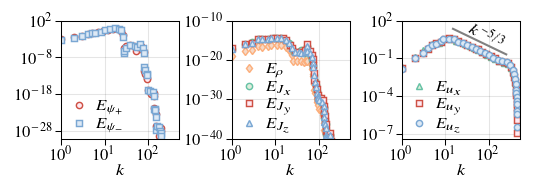

In [31]:
fig_width = 18/2.54
fig_height = 18/2.54
fig = plt.figure(figsize=(fig_width, fig_height))

ax_width = 2/2.54 / fig_width
ax_height = ax_width


# 
ax = fig.add_axes([0, 0, ax_width, ax_height])
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1)
ax.loglog(k, E_psi1, linestyle='none', marker='o', markersize=3, markevery=(0.03/2, 0.03), markerfacecolor='#FFE9F1', markeredgecolor='#CE5044', markeredgewidth=0.7, label=r'$E_{\psi_+}$')
ax.loglog(k, E_psi2, linestyle='none', marker='s', markersize=3, markevery=(0, 0.03), markerfacecolor='#DDE9F5', markeredgecolor='#7AA7D3', markeredgewidth=0.7, label=r'$E_{\psi_-}$')
ax.legend(ncol=1, frameon=False, labelspacing=0.2, handlelength=2.2, handletextpad=0.0, bbox_to_anchor=(-0.1, -0.06), loc='lower left', fontsize=fontsize-1)
plt.xlim(1, N)
plt.ylim(1e-30, 1e2)
plt.xlabel(r'$k$', labelpad=0, size=fontsize)
# plt.ylabel(r'$E_\psi$', labelpad=1, size=fontsize) # rotation=0
ax.set_yticks([1e-28, 1e-18, 1e-8, 1e2])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, width=0.5, length=3, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, width=0.5, length=3, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=0)


# 
ax = fig.add_axes([ax_width+0.049, 0, ax_width, ax_height])
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1)
ax.loglog(k, E_rho, linestyle='none', marker='d', markersize=3, markevery=(0.03/2, 0.03), markerfacecolor="#F5D9C7", markeredgecolor='#FCAF7C', markeredgewidth=0.7, label=r'$E_{\rho}$')
ax.loglog(k, E_Jx, linestyle='none', marker='o', markersize=3, markevery=(0.03/2, 0.03), markerfacecolor='#dfeddc', markeredgecolor='#66c2a5', markeredgewidth=0.7, label=r'$E_{J_x}$')
ax.loglog(k, E_Jy, linestyle='none', marker='s', markersize=3, markevery=(0.03/2, 0.03), markerfacecolor='#FFE9F1', markeredgecolor='#CE5044', markeredgewidth=0.7, label=r'$E_{J_y}$')
ax.loglog(k, E_Jz, linestyle='none', marker='^', markersize=3, markevery=(0.03/2, 0.03), markerfacecolor='#DDE9F5', markeredgecolor='#7AA7D3', markeredgewidth=0.7, label=r'$E_{J_z}$')
ax.legend(ncol=1, frameon=False, labelspacing=0.2, handlelength=2.2, handletextpad=0.0, bbox_to_anchor=(-0.1, -0.06), loc='lower left', fontsize=fontsize-1)
plt.xlim(1, N)
plt.ylim(1e-40, 1e-10)
plt.xlabel(r'$k$', labelpad=0, size=fontsize)
# plt.ylabel(r'$E_\psi$', labelpad=1, size=fontsize) # rotation=0
ax.set_yticks([1e-40, 1e-30, 1e-20, 1e-10])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, width=0.5, length=3, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, width=0.5, length=3, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=0)


# 
ax = fig.add_axes([2*ax_width+0.098, 0, ax_width, ax_height])
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1)
ax.loglog(k, E_ux, linestyle='none', marker='^', markersize=3, markevery=(0, 0.03), markerfacecolor='#dfeddc', markeredgecolor='#66c2a5', markeredgewidth=0.7, label=r'$E_{u_x}$')
ax.loglog(k, E_uy, linestyle='none', marker='s', markersize=3, markevery=(0.03/2, 0.03), markerfacecolor='#FFE9F1', markeredgecolor='#CE5044', markeredgewidth=0.7, label=r'$E_{u_y}$')
ax.loglog(k, E_uz, linestyle='none', marker='o', markersize=3, markevery=(0.03/2, 0.03), markerfacecolor='#DDE9F5', markeredgecolor='#7AA7D3', markeredgewidth=0.7, label=r'$E_{u_z}$')
ax.loglog(np.linspace(15, N//3+80, 100), 2e3*np.linspace(15, N//3+80, 100)**(-5/3), linestyle='-', linewidth=1, color='grey')
ax.text(30, 5e-1, r'$k^{-5/3}$', rotation=-30)
ax.legend(ncol=1, frameon=False, labelspacing=0.2, handlelength=2.2, handletextpad=0.0, bbox_to_anchor=(-0.1, -0.06), loc='lower left', fontsize=fontsize-1)
plt.xlim(1, N)
# plt.ylim(1e-8, 1e-1)
plt.xlabel(r'$k$', labelpad=0, size=fontsize)
ax.set_yticks([1e-7, 1e-4, 1e-1, 1e2])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.tick_params(axis='x', which='major', direction='out', top=False, right=False, width=0.5, length=3, pad=1.5)
ax.tick_params(axis='y', which='major', direction='out', top=False, right=False, width=0.5, length=3, pad=1)
ax.tick_params(which='minor', direction='out', top=False, right=False, length=0)


# 
plt.savefig(fr'figure.pdf', transparent=True, orientation='portrait', format='pdf', bbox_inches='tight')

Volumn rendering of $\rho$

In [18]:
def compute_div_vel(ux, uy, uz):
    h = 2*pi / N
    div_vel = (np.roll(ux, -1, axis=2) - np.roll(ux, 1, axis=2) + np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1) + np.roll(uz, -1, axis=0) - np.roll(uz, 1, axis=0)) / (2*h)
    return div_vel

div_vel = compute_div_vel(ux, uy, uz)

In [ ]:
import pyvista as pv
from matplotlib.colors import LinearSegmentedColormap

cmap_BuRd = LinearSegmentedColormap.from_list('cmap_BuRd', ['#1763b2', '#86c5e5', '#ffffff', '#f69d74', '#b80f24'])

grid = pv.ImageData()
dims = (N, N, N)
grid.dimensions = dims
grid.spacing = (1, 1, 1)

grid['amplitude'] = rho.flatten(order='F')

plotter = pv.Plotter(notebook=False, off_screen=True)   # output to file: off_screen=True)

vol = plotter.add_volume(
    grid,
    scalar_bar_args={'title': 'Amplitude'},
    cmap='inferno',
    clim=[0, 1e-6],
    opacity='sigmoid',
    show_scalar_bar=False
)

plotter.add_mesh(grid.outline(), color='grey', line_width=10)

plotter.enable_anti_aliasing() 
light = pv.Light()
light.intensity = 0.5      
light.positional = True    
light.position = (6, 9, 9)    
# light.show_actor()           
plotter.add_light(light)

plotter.camera.azimuth = 70
plotter.camera.elevation = -15
plotter.disable_parallel_projection()    

plotter.show(screenshot=fr'figures/rho_vol_1e-6.png', window_size=[3000, 3000])